Threshold optimization - Random Forest Trading strategy.
This notebook studies the impact of the signal threshold (quantile-based) on the performance of Random Forest trading strategy using stochasic features.
We keep :
 - the model fixed 
 - the data fixed 
 - the features fixed 
only the decision threshold varies.

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path.cwd().parents[0]
sys.path.append(str(project_root))

from src.data.fetcher import (
    get_single_ticker,
    get_vix,
    get_risk_free_rate
)

from src.data.features import FeatureEngineer, prepare_model_data
from src.models.ml_models import make_random_forest
from src.evaluation.backtest import backtest_signals

In [2]:
start = "2015-01-01"
end = "2024-01-01"
split_date = "2020-01-01"

spy = get_single_ticker("SPY", start, end, use_cache=True)
vix = get_vix(start, end, use_cache=True)
rf = get_risk_free_rate(start, end, use_cache=True)

fe = FeatureEngineer()
features_df = fe.create_all_features(spy, vix=vix, rf=rf)

X, y_reg, y_clf = prepare_model_data(features_df, fe, dropna=True)

common_idx = X.index.intersection(y_reg.index)
X = X.loc[common_idx]
y_reg = y_reg.loc[common_idx]

Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for SPY...
✓ Data for SPY cached at data/raw/SPY_1d.csv.
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^VIX...
✓ Data for ^VIX cached at data/raw/^VIX_1d.csv.
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^IRX...
✓ Data for ^IRX cached at data/raw/^IRX_1d.csv.
Creating features...
Returns added
Momentum added
Volatility added
RSI added
Volume features added
VIX added
Risk-free rate added
Target created
Data prepared: 2142 valid samples
Dropped 122 rows with NaN


In [3]:
#Time-based split to avoid look-ahead bias and ensure realistic out-of-sample evaluation consistent with a live trading conditions
train_mask = X.index < split_date
test_mask = X.index >= split_date

X_train = X.loc[train_mask]
X_test = X.loc[test_mask]

y_train = y_reg.loc[train_mask]
y_test = y_reg.loc[test_mask]

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 1137
Test size: 1005


In [4]:
#The model is trained one and kept fixed to isolate the effect of the decision threshold (ceteris paribus analysis)
rf_model = make_random_forest(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = pd.Series(
    rf_model.predict(X_test),
    index=X_test.index,
    name="prediction"
)

Run a backtest for a fixed model while varying only the signal threshold.
This isolates the impact of the decision rule on performance.

In [ ]:
def run_backtest_for_threshold(predictions, returns, threshold):
    cutoff = predictions.quantile(threshold)
    signals = (predictions > cutoff).astype(int)

    bt = backtest_signals(
        returns=returns,
        signals=signals,
        trading_cost_bps=1.0,
        starting_capital=1.0
    )

    ret = bt.strategy_returns
    equity = (1 + ret).cumprod()

    sharpe = (ret.mean() / ret.std()) * np.sqrt(252) if ret.std() > 0 else 0.0
    total_return = (equity.iloc[-1] - 1) * 100
    time_in_market = signals.mean() * 100

    return sharpe, total_return, time_in_market, equity

In [6]:
#Evaluate strategy performance across multiple thresholds to study the trade-off between selectivity and time-in-market
thresholds = np.arange(0.3, 0.9, 0.1)

results = []

equity_curves = {}

for thr in thresholds:
    sharpe, total_ret, tim, equity = run_backtest_for_threshold(
        y_pred, y_test, thr
    )

    results.append({
        "Threshold": thr,
        "Sharpe": sharpe,
        "Total Return (%)": total_ret,
        "Time in Market (%)": tim
    })

    equity_curves[thr] = equity

results_df = pd.DataFrame(results)
results_df


,Threshold,Sharpe,Total Return (%),Time in Market (%)
0,0.3,0.645429,55.190998,69.950249
1,0.4,0.661433,56.279188,60.000000
2,0.5,0.506461,37.456943,49.950249
3,0.6,0.535523,39.631811,40.000000
4,0.7,0.397218,25.018527,30.049751
5,0.8,0.287991,14.803188,20.000000
6,0.9,0.262156,11.991829,10.049751


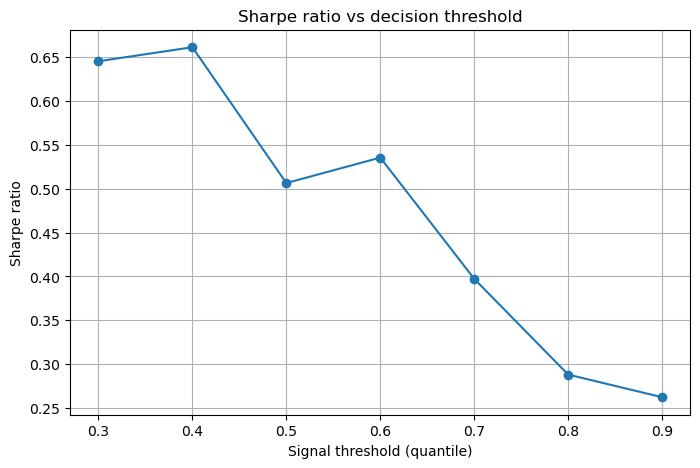

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["Threshold"], results_df["Sharpe"], marker="o")
plt.xlabel("Signal threshold (quantile)")
plt.ylabel("Sharpe ratio")
plt.title("Sharpe ratio vs decision threshold")
plt.grid(True)
plt.show()

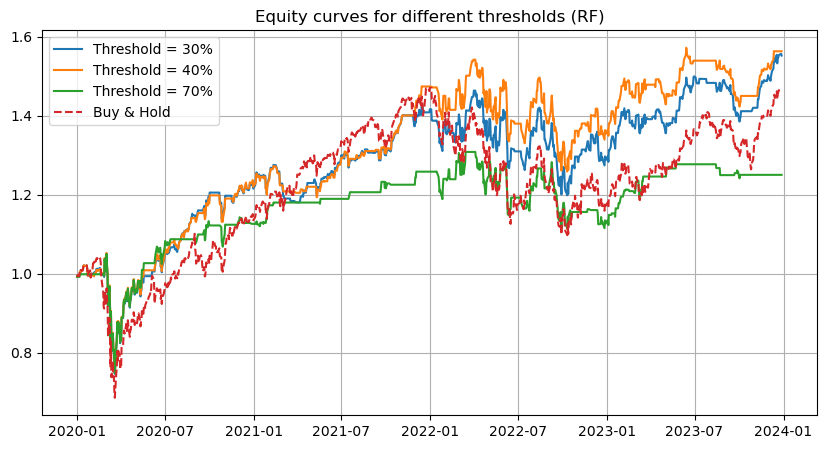

In [8]:
equity_curves_clean = {
    round(float(k), 2): v
    for k, v in equity_curves.items()
}
plt.figure(figsize=(10, 5))

for thr in [0.3, 0.4, 0.7]:
    plt.plot(
        equity_curves_clean[thr],
        label=f"Threshold = {int(thr*100)}%"
    )

plt.plot(
    (1 + y_test).cumprod(),
    linestyle="--",
    label="Buy & Hold"
)

plt.title("Equity curves for different thresholds (RF)")
plt.legend()
plt.grid(True)
plt.show()



Conclusion
- Strategy performance is highly sensitive to the decision threshold used to generate trading signals.
- Lower thresholds increase market exposure, resulting in higher return variance due to greater participation in market fluctuations.
- Intermediate thresholds (around 40–50%) achieve the best trade-off between return and risk, as measured by the Sharpe ratio.
- Threshold selection is therefore a critical design choice and should be calibrated empirically rather than set arbitrarily.